In [1]:
import numpy as np_ # Original numpy 
import scipy as sp

import random

# Plot
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# qnode device
dev = qml.device('default.mixed', wires = 1)

# Building hamiltonian
coeffs = [-0.5]
obs = [qml.PauliZ(0)]

hamiltonian = qml.Hamiltonian(coeffs, obs)  # Define Hamiltonian

In [2]:
# Global paras 
Paras_global, Phi_global, Gamma_ps  = np.zeros(3), 0, 0

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""

    Calculate_Gamma = 1 - np.exp(-2 * tau)
    
    return Calculate_Gamma    # Return gamma

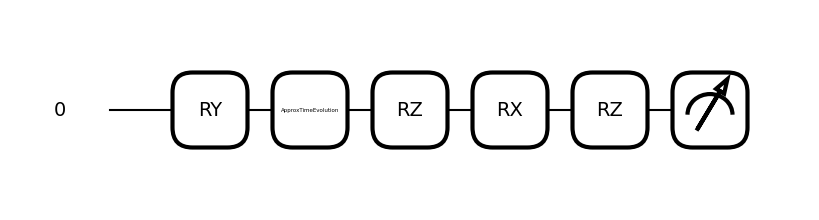

In [3]:
@qml.qnode(dev)
def circuit(phi):
    global Paras_global
    phi_z1, phi_z2, theta_x = Paras_global[0], Paras_global[1], Paras_global[2] 

    qml.RY(np.pi/2, wires = 0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)

    qml.RZ(phi_z1, wires = 0)  # phi_z1
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    qml.RZ(phi_z2, wires = 0)  # phi_z2
    
    return qml.density_matrix(wires = 0)

paras_plot = 1,1
fig, ax = qml.draw_mpl(circuit)(paras_plot)

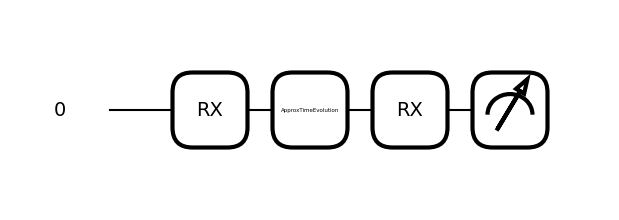

In [4]:
@qml.qnode(dev)
def circuit_explict(phi):
    qml.RX(np.pi/2, wires = 0)  # theta_x

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
        
    qml.RX(np.pi/2, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)

paras_plot = 1
fig, ax = qml.draw_mpl(circuit_explict)(paras_plot)

$$
Equivalent \quad to \quad RY(pi/2)?
$$

$$
RY(pi/2)
\quad

TimeEvo(phi)
\quad

RZ(pi/2)
\quad

RX(pi/2)
$$

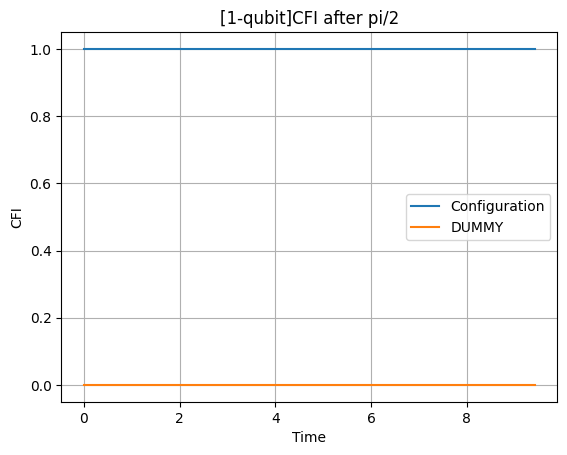

In [5]:
CFI_Data_Explict = np.arange(1e-4, np.pi * 3 + 1e-4, 1e-2)
DATA_Explict = np.zeros(len(CFI_Data_Explict))
DUMMY = np.zeros(len(CFI_Data_Explict))

for i in range(len(CFI_Data_Explict)):
    DATA_Explict[i] = qml.qinfo.classical_fisher(circuit_explict)(CFI_Data_Explict[i])
    
plt.title(f'[1-qubit]CFI after pi/2')
plt.plot(CFI_Data_Explict, DATA_Explict, label = 'Configuration')
plt.plot(CFI_Data_Explict, DUMMY, label = 'DUMMY')

plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

In [6]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(circuit)(phi[0])
    
    return -CFI

In [7]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    """ Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        Sweep_Data (numpy_array): Range of data sweeps.
        paras (numpy_array): Array of 3 parameters for the qnode.
        gamma_ps_select (int): The Gamma value for post-selection.
        Iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array
    """
    
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # INDEX CONSTANT
    CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Before optimization; CFI data
    for Phi_Index in range(len(PHI)):
        Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
        for Paras_Index_Array in range(len(paras)):
            Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][PARAS_INDEX + Paras_Index_Array] = paras[Paras_Index_Array]
        
        
    # Optimize begin
    for Layer_Index in range(1, Iterations + 1):
        for Phi_Index in range(len(PHI)):
            # Load previous paras
            Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
            # Set Phi(Currently sweeping)
            Phi_global = Data[Layer_Index][Phi_Index][0]
            
            # Constraints(gamma = 0.99..) 
            tau_upper = 18
            # Constraints = [(-float('inf'), float('inf'))] * 3
            Constraints = [(0, np.pi)] * 3
            
            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(Cost_function, Paras_Temporary, method = 'L-BFGS-B', bounds = Constraints)
            Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
            # Store data in array
            for Paras_Index_Array in range(len(Paras_Temporary)):
                Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

$$
Data[Layer][Row][Col] = [PHI, \quad CFI, \quad theta_x, \quad phi_z]
$$

In [8]:
# == Sweep for 0 ~ pi*3 == 
Step = 1e-2
Sweep_data = np_.array([1e-4, np.pi * 1 + 1e-4, Step])

Paras_init = np.zeros(3)
Paras_init[:3] = 1

Gamma_ps_preset = 1e-6
Set_Iterations = 1

Optimized_Result = BFGS(Sweep_data, Paras_init, Gamma_ps_preset, Set_Iterations)

print(Paras_init)

[1. 1. 1.]


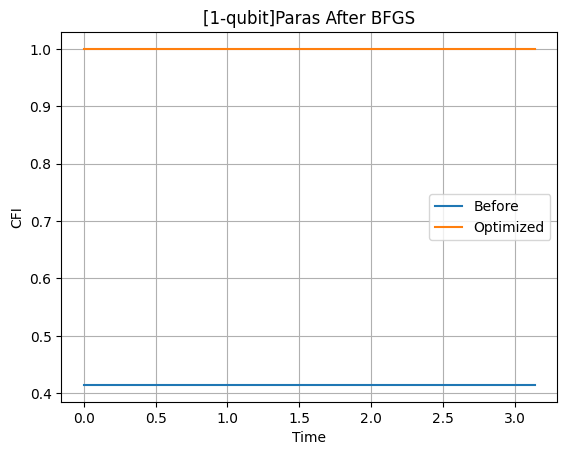

In [9]:
plt.title(f'[1-qubit]Paras After BFGS')

DUMMY = np.zeros(len(Optimized_Result[0][:, 0]))
plt.plot(Optimized_Result[0][:, 0], Optimized_Result[0][:, 1], label = 'Before')
plt.plot(Optimized_Result[0][:, 0], Optimized_Result[1][:, 1], label = 'Optimized')
# plt.plot(Optimized_Result[0][:, 0], DUMMY, label = 'DUMMY')

plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

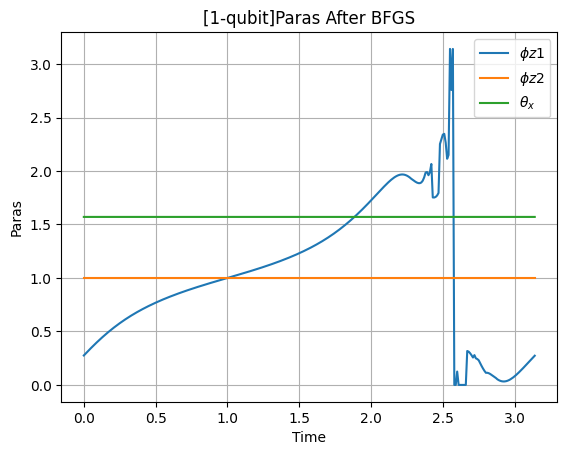

In [10]:
plt.title(f'[1-qubit]Paras After BFGS')

plt.plot(Optimized_Result[0][:, 0], Optimized_Result[1][:, 2], label = r'$\phi{z1}$')
plt.plot(Optimized_Result[0][:, 0], Optimized_Result[1][:, 3], label = r'$\phi{z2}$')
plt.plot(Optimized_Result[0][:, 0], Optimized_Result[1][:, 4], label = r'$\theta_{x}$')

plt.xlabel('Time')
plt.ylabel('Paras')
plt.grid()
plt.legend()

In [11]:
Optimized_Result[1][:, 2]

array([0.27538844, 0.28953537, 0.30356226, 0.31745472, 0.3312009 ,
       0.34479045, 0.35821465, 0.3714661 , 0.38453851, 0.39742655,
       0.4101258 , 0.42263266, 0.43494389, 0.44705741, 0.45897121,
       0.47068407, 0.48219537, 0.49350453, 0.50461204, 0.51551837,
       0.52622452, 0.53673188, 0.54704216, 0.55715742, 0.56708004,
       0.57681265, 0.58635821, 0.59571967, 0.60490045, 0.61390395,
       0.62273376, 0.63139359, 0.6398873 , 0.64821879, 0.65639182,
       0.66441046, 0.67227856, 0.68000015, 0.68757904, 0.69501925,
       0.70232451, 0.70949859, 0.71654518, 0.72346805, 0.73027014,
       0.73695633, 0.74352914, 0.74999201, 0.75634796, 0.76260049,
       0.76875253, 0.77480712, 0.78076715, 0.78663558, 0.79241517,
       0.79810852, 0.80371857, 0.80924748, 0.81469812, 0.82007276,
       0.82537383, 0.83060373, 0.83576469, 0.84085901, 0.84588879,
       0.85085633, 0.85576358, 0.86061268, 0.8654057 , 0.87014466,
       0.8748314 , 0.87946802, 0.88405633, 0.88859827, 0.89309

In [12]:
Optimized_Result[1][:, 3]

array([1.00000001, 1.        , 1.00000003, 1.00000004, 0.99999999,
       1.        , 0.99999999, 1.00000001, 0.99999998, 0.99999999,
       0.99999996, 1.00000001, 1.00000002, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.00000001, 1.00000001,
       1.00000002, 1.        , 1.        , 1.00000001, 1.00000003,
       1.00000001, 1.00000001, 1.00000001, 1.        , 1.00000005,
       1.00000002, 1.00000003, 0.99999999, 1.00000001, 1.        ,
       0.99999999, 1.00000001, 1.        , 1.00000001, 1.        ,
       1.00000001, 1.        , 1.00000002, 1.00000001, 1.00000001,
       1.        , 1.        , 1.00000001, 1.00000001, 1.00000003,
       1.00000001, 1.00000001, 1.        , 1.        , 0.99999998,
       1.        , 1.00000001, 1.00000001, 1.00000002, 1.        ,
       0.99999999, 1.00000002, 1.00000001, 0.99999999, 1.        ,
       1.        , 1.00000001, 1.00000001, 1.00000001, 1.00000001,
       1.        , 1.00000001, 1.        , 1.        , 0.99999

In [13]:
Optimized_Result[1][:, 4]

array([1.57079694, 1.5707971 , 1.57079733, 1.5707975 , 1.57079774,
       1.57079796, 1.57079818, 1.57079837, 1.57079855, 1.5707987 ,
       1.57079877, 1.57079888, 1.5707989 , 1.57079884, 1.5707988 ,
       1.57079875, 1.57079861, 1.57079847, 1.57079832, 1.57079816,
       1.57079797, 1.57079777, 1.5707976 , 1.57079746, 1.57079728,
       1.57079712, 1.570797  , 1.57079686, 1.57079676, 1.57079669,
       1.5707966 , 1.57079656, 1.57079652, 1.57079648, 1.5707964 ,
       1.57079641, 1.5707964 , 1.57079636, 1.57079636, 1.57079633,
       1.57079633, 1.57079633, 1.57079635, 1.57079635, 1.57080023,
       1.57079879, 1.57079777, 1.57079709, 1.57079663, 1.57079641,
       1.57079632, 1.57079639, 1.5707965 , 1.57079668, 1.57079694,
       1.57079713, 1.57079739, 1.57079759, 1.5707978 , 1.57079797,
       1.5707981 , 1.57079823, 1.57079829, 1.57079835, 1.57079834,
       1.57079835, 1.57079833, 1.57079825, 1.57079814, 1.57079803,
       1.57079791, 1.57079778, 1.57079764, 1.57079752, 1.57079